In [1]:
# Francisco Dominguez Mateos
# 24/06/2020
# it is just a rough implementation of a MLP with jax.stax
# by today BatchNorm doesn't seem to work with Dense but it works with Conv look at jax_cnn_
#From:https://roberttlange.github.io/posts/2020/03/blog-post-10/

In [2]:
#!conda install -c pytorch pytorch --yes
#!conda install -c pytorch torchvision --yes
#!conda install -c anaconda seaborn --yes

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import time
import numpy as onp
import jax.numpy as np
from jax import grad, jit, vmap, value_and_grad
from jax import random

In [110]:
# Import some additional JAX and dataloader helpers
from jax.scipy.special import logsumexp
from jax.experimental import optimizers
# Using STAC the ANN library of JAX
from jax.experimental import stax
from jax.experimental.stax import BatchNorm, Dense, Relu, LogSoftmax

import torch
from torchvision import datasets, transforms

#from: https://github.com/RobertTLange/code-and-blog/blob/master/04_jax_intro/helpers.py
#!conda install -c anaconda seaborn --yes
from helpers import plot_mnist_examples
from helpers import plot_mnist_performance

In [46]:
# Generate key which is used to generate random numbers
key = random.PRNGKey(1)

In [47]:
# Set the PyTorch Data Loader for the training & test set
batch_size = 100

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./pytorch_data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./pytorch_data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)

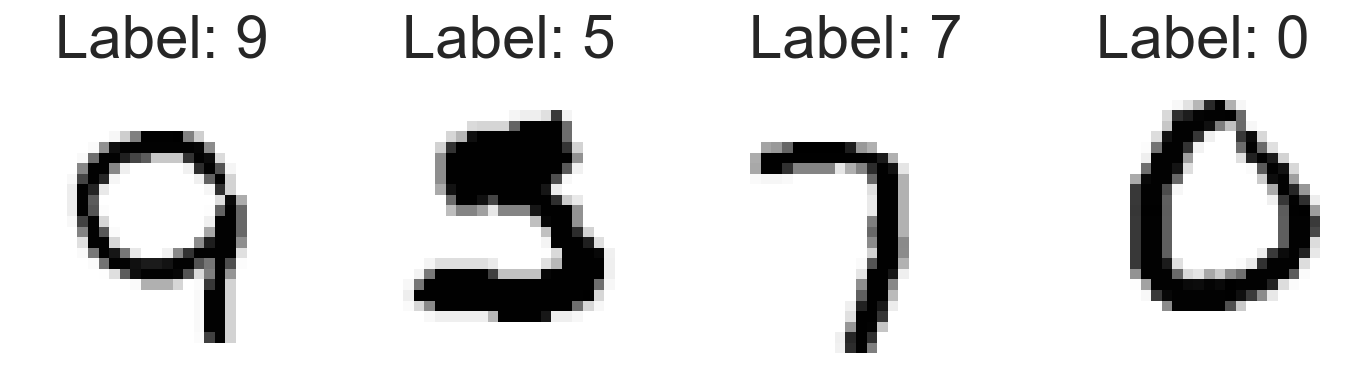

In [48]:
plot_mnist_examples(train_loader)

In [101]:
num_classes=10
init_mlp, mlp = stax.serial(Dense(128),
                            #BatchNorm(), #doesn't seem to work with Dense!!!
                            Relu,
                            Dense(128),
                            #BatchNorm(),
                            Relu,
                            Dense(num_classes),
                            LogSoftmax)

In [112]:
in_shape = (-1, 28*28,)
_, params = init_mlp(key, in_shape)
fake_data=random.uniform(key,(100,28*28))
print(fake_data.shape)
mlp(params,fake_data).shape

(100, 784)


(100, 10)

In [117]:
def one_hot(x, k, dtype=np.float32):
    """Create a one-hot encoding of x of size k """
    return np.array(x[:, None] == np.arange(k), dtype)

def accuracy(params, data_loader):
    """ Compute the accuracy for a provided dataloader """
    acc_total = 0
    for batch_idx, (data, target) in enumerate(data_loader):
        # flattening
        images = np.array(data).reshape(data.size(0), 28*28)
        targets = one_hot(np.array(target), num_classes)

        target_class = np.argmax(targets, axis=1)
        preds=mlp(params,images)
        predicted_class = np.argmax(preds, axis=1)
        acc_total += np.sum(predicted_class == target_class)
    return acc_total/len(data_loader.dataset)

def loss(params, images, targets):
    preds = mlp(params, images)
    return -np.sum(preds * targets)

In [105]:
# Defining an optimizer in Jax
step_size = 1e-3
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)
num_epochs = 10

In [106]:
@jit
def update(params, x, y, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(loss)(params, x, y)
    opt_state = opt_update(0, grads, opt_state)
    return get_params(opt_state), opt_state, value

In [115]:
def run_mnist_training_loop(num_epochs, opt_state):
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    log_acc_train, log_acc_test, train_loss = [], [], []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Get initial accuracy after random init
    train_acc = accuracy(params, train_loader)
    test_acc  = accuracy(params, test_loader)
    log_acc_train.append(train_acc)
    log_acc_test.append(test_acc)

    # Loop over the training epochs
    for epoch in range(num_epochs):
        start_time = time.time()
        for batch_idx, (data, target) in enumerate(train_loader):
            # Flatten the image into 784 vectors for the MLP
            x = np.array(data).reshape(data.size(0), 28*28)
            y = one_hot(np.array(target), num_classes)
            params, opt_state, loss = update(params, x, y, opt_state)
            train_loss.append(loss)

        epoch_time = time.time() - start_time
        train_acc  = accuracy(params, train_loader)
        test_acc   = accuracy(params, test_loader)
        log_acc_train.append(train_acc)
        log_acc_test.append(test_acc)
        print("Epoch {} | T: {:0.2f} | Train A: {:0.3f} | Test A: {:0.3f}".format(epoch+1, epoch_time,
                                                                    train_acc, test_acc))
    return train_loss, log_acc_train, log_acc_test

In [118]:
train_loss, train_log, test_log = run_mnist_training_loop(num_epochs,
                                                          opt_state)

Epoch 1 | T: 7.88 | Train A: 0.965 | Test A: 0.959
Epoch 2 | T: 8.01 | Train A: 0.978 | Test A: 0.970
Epoch 3 | T: 7.82 | Train A: 0.982 | Test A: 0.972
Epoch 4 | T: 7.83 | Train A: 0.988 | Test A: 0.975
Epoch 5 | T: 7.81 | Train A: 0.989 | Test A: 0.976
Epoch 6 | T: 7.99 | Train A: 0.991 | Test A: 0.975
Epoch 7 | T: 7.90 | Train A: 0.992 | Test A: 0.976
Epoch 8 | T: 7.85 | Train A: 0.996 | Test A: 0.978
Epoch 9 | T: 7.90 | Train A: 0.996 | Test A: 0.979
Epoch 10 | T: 7.79 | Train A: 0.997 | Test A: 0.978


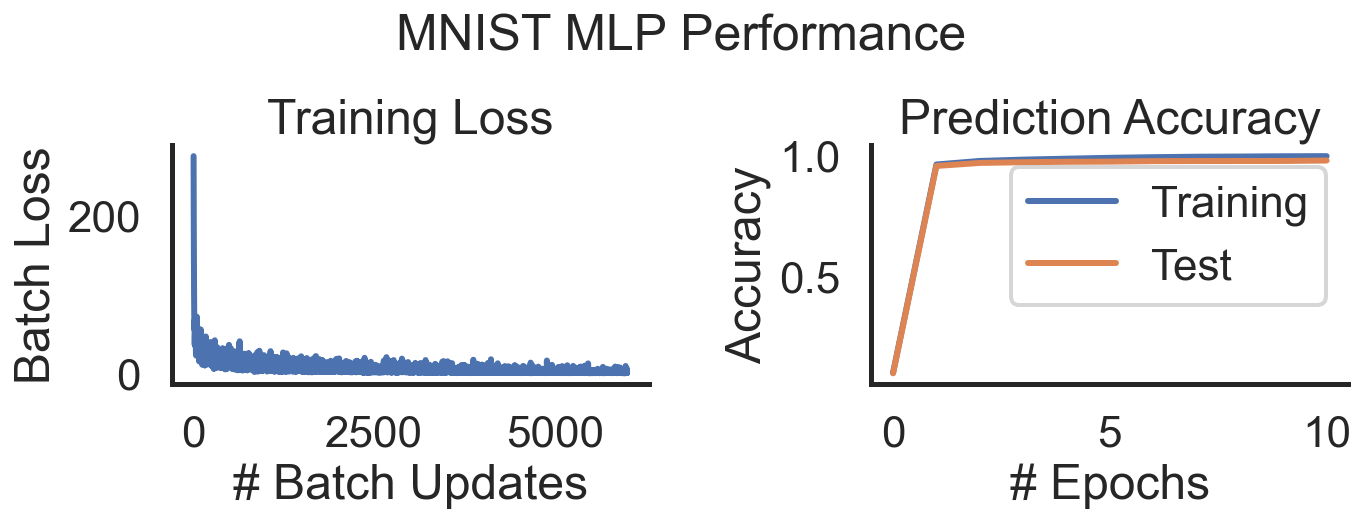

In [111]:
plot_mnist_performance(train_loss, train_log, test_log,
                       "MNIST MLP Performance")